# EarlyDarkEmu

> GP emulator for power spectra in Early Dark Energy model

emulator for P(k) for dark matter power spectra

## Install

(not installable yet)
```sh
pip install EarlyDarkEmu
```

(Use this development version instead)

```sh
git clone https://github.com/nesar/EarlyDarkEmu.git
cd EarlyDarkEmu/
pip install -e '.[dev]'
```

## Basic rundown

### A few imports 

In [ ]:
from EarlyDarkEmu.load import *
from EarlyDarkEmu.viz import *
from EarlyDarkEmu.pca import *
from EarlyDarkEmu.gp import *
from EarlyDarkEmu.emu import *
from EarlyDarkEmu.mcmc import *


import pandas as pd
import numpy as np
import matplotlib.pylab as plt


if_train_all = False ## Re-train all the models. Time-consuming. 
if_mcmc_all = False  ## Full MCMC run. Time-consuming. 
if_savefig = False

if_pk_log = True ## P(k) is to be in log10 scaling 
if_y_scale_plot_log = not if_pk_log
if_separate_test_set = True


(210,)


### Loading files

In [ ]:
p_all = load_params() ## Loading Cosmological Parameters
Pk_all, k_all, z_all = load_npy_pk_k_z(pk_log_scale=if_pk_log) # Loading P(k), k and redshift

print(p_all.shape, Pk_all.shape, k_all.shape, z_all.shape, PARAM_NAME)
print(len(PARAM_NAME))

remove_invalid_index = False
if remove_invalid_index == True:
    remove_sim_indx = [None]
    valid_indices = [i for i in  np.arange(Pk_all.shape[0])  if i not in remove_sim_indx]

    Pk_all = Pk_all[valid_indices]
    p_all = p_all[valid_indices]

(64, 6) (64, 51, 210) (210,) (51,) ['$\\omega_m$', 'h', '$\\sigma_8$', '$\\log(z_c)$', '$f_{ede}$', '$\\theta_i$']
6


### A few plotting routines

#### Experimental design

#### Boost metrics colored by cosmology parameters

<ErrorbarContainer object of 3 artists>

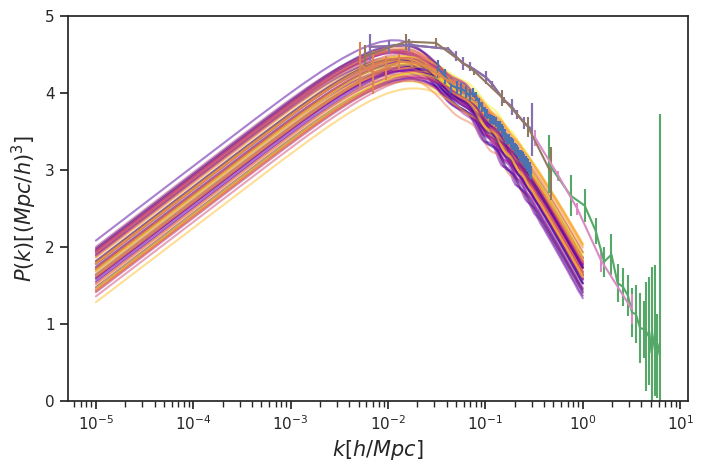

In [ ]:
color_by_index = 0
z_index = 0

plot_lines_with_param_color(p_all[:, color_by_index], 
                            k_all, 
                            Pk_all[:, z_index, :], 
                            'Training data, z=' + str(z_all[z_index]), 
                            r'$k [h/Mpc]$', 
                            r'$P(k) [(Mpc/h)^3]$', 
                            PARAM_NAME[color_by_index],
                            y_log_plot_scale=if_y_scale_plot_log);

k_sdss, pk_sdss, pk_error_sdss = load_sdss()
k_wmap, pk_wmap, pk_error_wmap = load_wmap()
k_lya, pk_lya, pk_error_lya = load_lya()
k_plee, pk_plee, pk_error_plee = load_planck_ee()
k_pltt, pk_pltt, pk_error_pltt = load_planck_tt()
k_pl, pk_pl, pk_error_pl = load_planck()
k_des, pk_des, pk_error_des = load_des()

plt.ylim(0,5)

plt.errorbar(k_sdss, pk_sdss, yerr=pk_error_sdss, label='SDSS DR7')
plt.errorbar(k_wmap, pk_wmap, yerr=pk_error_wmap, label='WMAP + ACT')
plt.errorbar(k_lya, pk_lya, yerr=pk_error_lya, label='eBOSS')
plt.errorbar(k_plee, pk_plee, yerr=pk_error_plee, label='PLANCK_2018 EE')
plt.errorbar(k_pltt, (pk_pltt), yerr=(pk_error_pltt), label='PLANCK_2018 TT')
plt.errorbar(k_pl, pk_pl, yerr=pk_error_pl, label='PLANCK_2018')
plt.errorbar(k_des, pk_des, yerr=pk_error_des, label='DES Y1 COSMIC SHEAR')

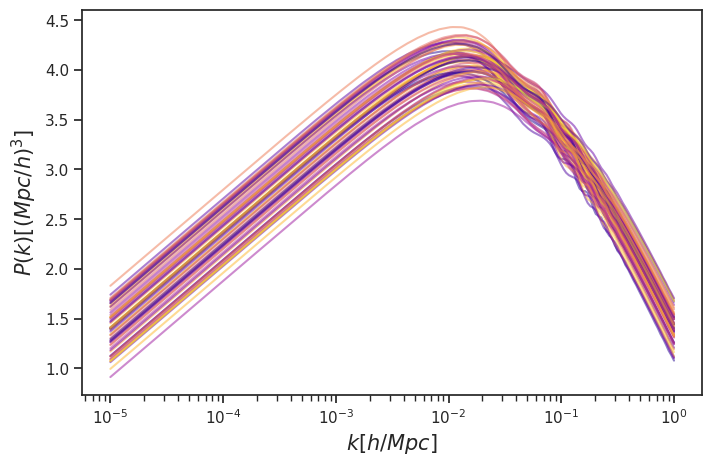

In [ ]:
#| hide 

color_by_index = 3
z_index = 21


plot_lines_with_param_color(p_all[:, color_by_index], 
                            k_all, 
                            Pk_all[:, z_index, :], 
                            'Training data, z=' + str(z_all[z_index]), 
                            r'$k [h/Mpc]$', 
                            r'$P(k) [(Mpc/h)^3]$', 
                            PARAM_NAME[color_by_index],
                            y_log_plot_scale=if_y_scale_plot_log);


# plt.legend()

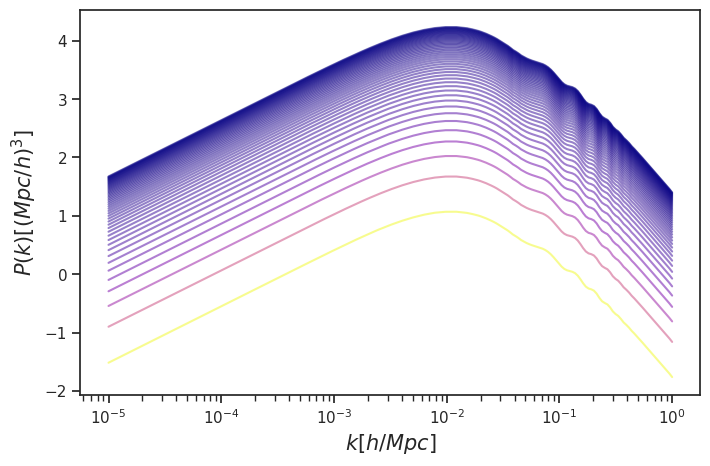

In [ ]:
#| hide 

z_index = 0

f = plot_lines_with_param_color(z_all, 
                            k_all, 
                            Pk_all[16, :, :], 
                            'Training data', 
                            r'$k [h/Mpc]$', 
                            r'$P(k) [(Mpc/h)^3]$', 
                            'redshift',
                            y_log_plot_scale=if_y_scale_plot_log);


### Training involves: PCA, GP fitting.  

In [ ]:
if not if_separate_test_set: 
    ## Data prep
    z_index = 1
    y_vals = Pk_all[:, z_index, :]
    # y_ind = np.arange(0, y_vals.shape[1])
    y_ind = k_all

    # Train-test split
    test_indices = [60, 30, 26]
    input_params= p_all[test_indices]
    target_vals = Pk_all[:, z_index, :][test_indices]


    train_indices = [i for i in  np.arange(Pk_all.shape[0]) if i not in test_indices]
    p_all_train = p_all[train_indices]
    y_vals_train = Pk_all[:, z_index, :][train_indices]
    print('Redshift: ' + str(z_all[z_index]))

In [ ]:


if if_separate_test_set:

    p_all_test = load_params(p_fileIn=LIBRARY_PARAM_FILE_TEST) 
                              ## Loading Cosmological Parameters
    Pk_all_test, k_all_test, z_all_test = load_npy_pk_k_z(Pk_fileIn=LIBRARY_PK_FILE_TEST, 
                                                          k_fileIn=LIBRARY_K_FILE_TEST, 
                                                          z_fileIn=LIBRARY_Z_FILE_TEST,
                                                          pk_log_scale=if_pk_log) # Loading P(k), k and redshift



    ## Data prep
    z_index = 1
    y_vals = Pk_all[:, z_index, :]
    # y_ind = np.arange(0, y_vals.shape[1])
    y_ind = k_all

    # Train-test split
    test_indices = []
    input_params= p_all_test
    target_vals = Pk_all_test[:, z_index, :]


    # train_indices = [i for i in  np.arange(Pk_all.shape[0]) if i not in test_indices]
    train_indices = [i for i in  np.arange(Pk_all.shape[0])]
    p_all_train = p_all[train_indices]
    y_vals_train = Pk_all[:, z_index, :][train_indices]
    print('Redshift: ' + str(z_all[z_index]))



Redshift: 0.02


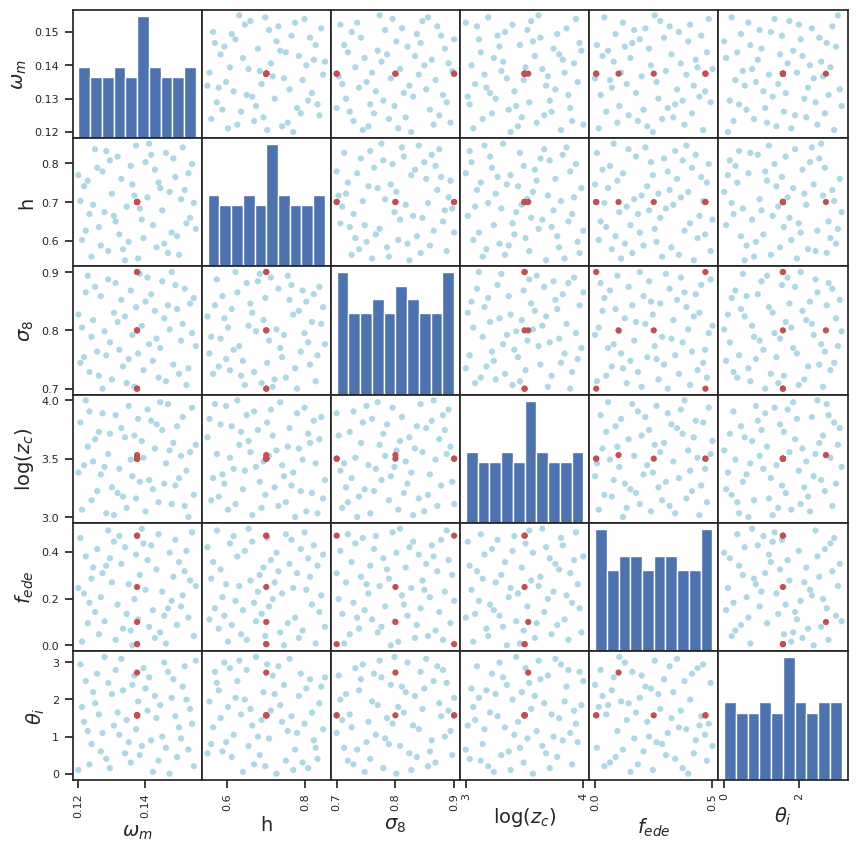

In [ ]:
df_train_a = pd.DataFrame(np.concatenate([p_all, p_all_test], axis=0), columns=PARAM_NAME)
colors = ['lightblue']*p_all.shape[0] + ['r']*p_all_test.shape[0]

# colors = ['b']*num_sims + ['r']*num_sims_test
plot_scatter_matrix(df_train_a, colors);

This SepiaData instance implies the following:
This is a simulator (eta)-only model, y dimension 210
m  =    64 (number of simulated data)
p  =     1 (number of inputs)
q  =     6 (number of additional simulation inputs)
pu NOT SET (transformed response dimension); call method create_K_basis 

Starting tune_step_sizes...
Default step sizes:
betaU
[[0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]]
lamUz
[[5. 5.]]
lamWs
[[100. 100.]]
lamWOs
[[100.]]


Step size tuning: 100%|█████████████████████████| 50/50 [00:05<00:00,  9.93it/s]


Done with tune_step_size.
Selected step sizes:
betaU
[[0.20654303 1.07272825]
 [0.03717023 0.13188897]
 [0.25422773 0.17042505]
 [0.03965561 0.14086564]
 [0.00388077 0.13123353]
 [0.0047564  0.37692349]
 [0.00111619 0.02588772]]
lamUz
[[0.41229222 0.51010359]]
lamWs
[[9161.88288534 1041.5495597 ]]
lamWOs
[[20.40418578]]


MCMC sampling: 100%|███████████████████████| 1000/1000 [00:05<00:00, 193.20it/s]


Model saved to ../EarlyDarkEmu/model/multivariate_model_z_index1.pkl
No thetas to plot


(None, <Figure size 1000x750 with 5 Axes>)

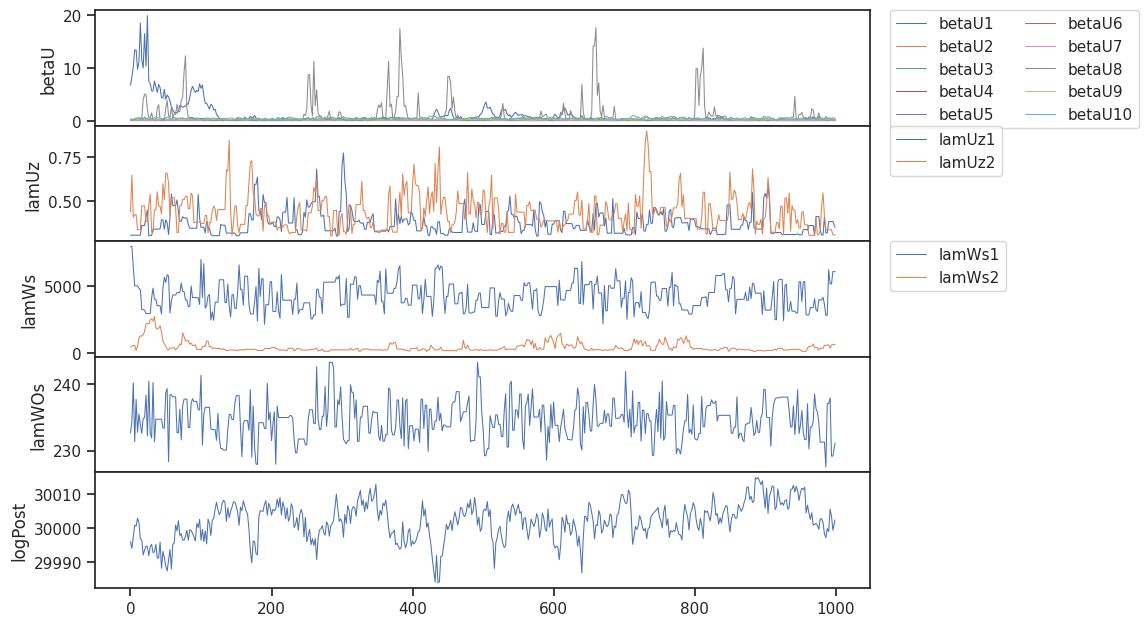

In [ ]:
sepia_data = sepia_data_format(p_all_train, y_vals_train, y_ind)
print(sepia_data)
model_filename = '../EarlyDarkEmu/model/multivariate_model_z_index' + str(z_index) 

sepia_model = do_pca(sepia_data, exp_variance=0.98)
sepia_model = do_gp_train(sepia_model, model_filename)
plot_train_diagnostics(sepia_model)

### Load existing model

In [ ]:
sepia_model = gp_load(sepia_model, model_filename)

### Single-redshift emulation for new cosmological parameters

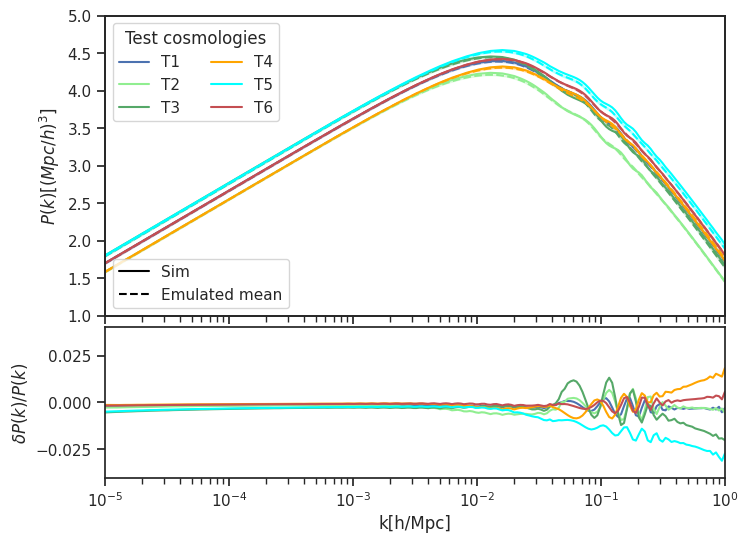

In [ ]:
# test_indices_rand = np.random.randint(size=3, low=0, high=input_params.shape[0])
test_indices_rand = np.arange(0, input_params.shape[0])
pred_mean, pred_quant = emulate(sepia_model, input_params[test_indices_rand])
# pred_quant == Emulated (0.05, 0.95) quantile
# validation_plot(k_all, target_vals[test_indices_rand], pred_mean, pred_quant, xy_lims=[1e-5, 1e0, 10, 5e4], y_log_scale=if_y_scale_plot_log);
validation_plot(k_all, target_vals[test_indices_rand], pred_mean, pred_quant, xy_lims=[1e-5, 1e0, 1, 5], y_log_plot_scale=if_y_scale_plot_log);

### Sensitivity analysis from the emulator 

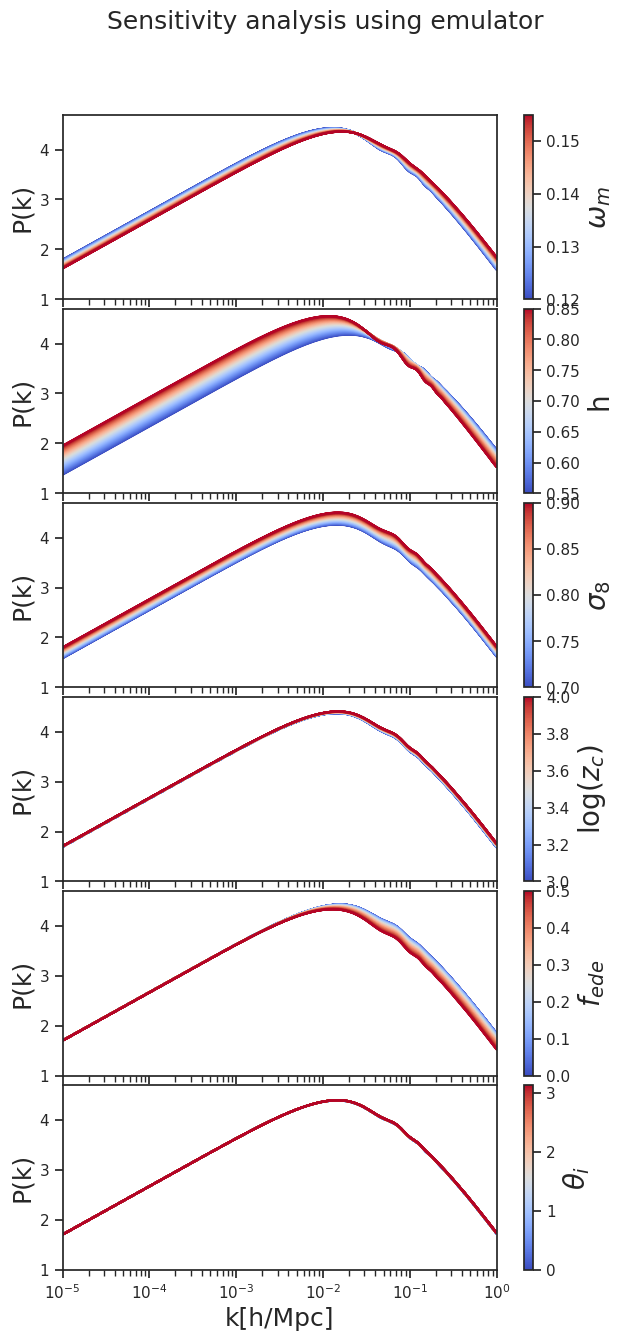

In [ ]:
# f = sensitivity_plot(k_all, p_all, sepia_model, emulate, PARAM_NAME, xy_lims = [1e-5, 1e0, 10, 5e4], y_log_plot_scale=if_y_scale_plot_log )
f = sensitivity_plot(k_all, p_all, sepia_model, emulate, PARAM_NAME, xy_lims = [1e-5, 1e0, 1, 4.7], y_log_plot_scale=if_y_scale_plot_log )

### Multi-redshift emulation

#### Train all the models

In [ ]:
if if_train_all:
    
    do_gp_train_multiple(model_dir='../EarlyDarkEmu/model/', 
                        p_train_all = p_all[train_indices],
                        y_vals_all = Pk_all[train_indices],
                        y_ind_all = k_all,
                        z_index_range=range(z_all.shape[0]))

#### Load all trained models 

In [ ]:
sepia_model_list = load_model_multiple(model_dir='../EarlyDarkEmu/model/', 
                                        p_train_all=p_all[train_indices],
                                        y_vals_all=Pk_all[train_indices],
                                        y_ind_all=k_all,
                                        z_index_range=range(z_all.shape[0]), 
                                        sepia_model_i=sepia_model)

Number of models loaded: 51


[[0.1375 0.7    0.7    3.5    0.47   1.57   0.05  ]]


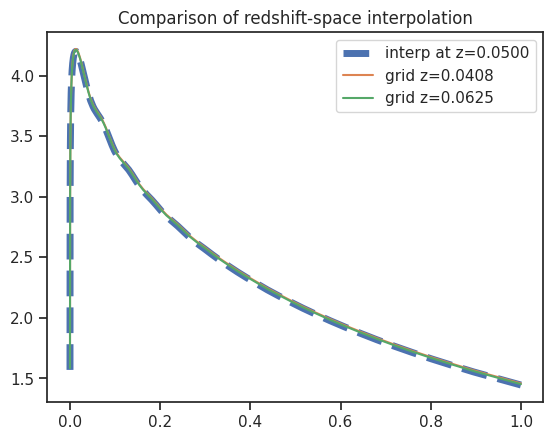

In [ ]:
#| hide

#### Emulator uncertainty across parameter range

input_params0 = input_params[1]
z_inputs = 0.05
input_params_and_redshift = np.append(input_params0, z_inputs)
print(input_params_and_redshift[np.newaxis, :])


emulated_with_redshift, emulated_with_redshift_err = emu_redshift(input_params_and_redshift[np.newaxis, :], sepia_model_list, z_all)


plt.figure(433)
plt.plot(k_all, emulated_with_redshift[:, 0], label='interp at z=%.4f'%input_params_and_redshift[-1], lw=5, ls='--')
plt.plot(k_all, emulate(sepia_model_list[0], input_params_and_redshift[:-1])[0], label='grid z=%.4f'%z_all[2])
plt.plot(k_all, emulate(sepia_model_list[1], input_params_and_redshift[:-1])[0], label='grid z=%.4f'%z_all[3])
plt.legend()
plt.title('Comparison of redshift-space interpolation')
# plt.plot(k_all, emulate(sepia_model_list[0], input_params))
# plt.plot(k_all, emulate(sepia_model_list[0], input_params))

plt.show()

#### Emulator confidence across parameter range

In [ ]:
# Parameter settings
steps = 20  # Number of steps in the grid for each parameter
param_name_extended = np.append(PARAM_NAME, 'Redshift')
red_min = 0
red_max = 3
red_mean = 1.0

param_min = np.append(p_all.min(axis=0), red_min)
param_max = np.append(p_all.max(axis=0), red_max)
param_mean = np.append(p_all.mean(axis=0), red_mean)

# Compute outputs and errors for a range of parameter values
def compute_errors(param_grid):
    print(param_grid.shape)
    errors = np.zeros(shape=(param_grid.shape[0], ))
    # errors = np.array([np.mean(emu_redshift(params[np.newaxis, :], sepia_model_list, z_all)[1][:, 0, :]**2) for params in param_grid])
    for par_indx in range(errors.shape[0]):

        errors[par_indx] = np.mean(emu_redshift(param_grid[par_indx][np.newaxis, :], sepia_model_list, z_all)[1]**2)

    return errors.reshape(steps, steps)


# Example usage:
param_indices = [3, 4]  # Indices of parameters to vary
fixed_indices = [i for i in range(len(param_name_extended)) if i not in param_indices]
fixed_params = {param_name_extended[i]: param_mean[i] for i in fixed_indices}

param_grid = generate_param_grid_with_fixed(param_name_extended, param_indices, fixed_params, param_min, param_max, steps)

In [ ]:
errors = compute_errors(param_grid)

(400, 7)


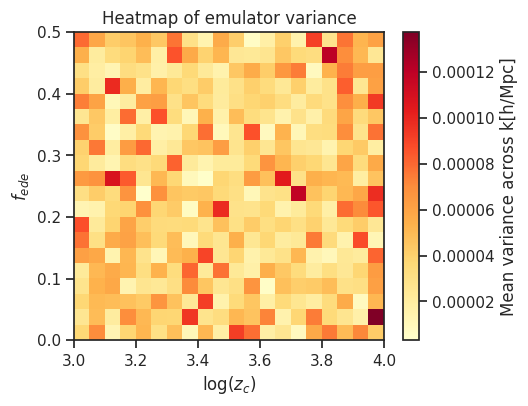

In [ ]:
f = plot_error_heatmap(errors, [param_name_extended[i] for i in param_indices], [(param_min[param_indices[0]], param_max[param_indices[0]]), (param_min[param_indices[1]], param_max[param_indices[1]])])

if if_savefig: 
    f.savefig('../../../Plots/heatmap_params_4_5.png', bbox_inches='tight')

### Parameter inference via MCMC using the emulator

In [ ]:
#| hide 

ndim = 6
nwalkers = 50  # 500
nrun_burn = 50  # 300
nrun = 400  # 1000

#### Creating mock observational data

In [ ]:
create_mock_obs = False

if create_mock_obs: 
    target_indx = 0 #0 ,14, 35
    z_index = 2
    L = 32
    fake_obs_data_index_every = 2

    redshift = z_all[z_index]
    x_target_mcmc = k_all[::fake_obs_data_index_every]
    y_target_mcmc = Pk_all[:, z_index, :][target_indx][::fake_obs_data_index_every]

    if not if_pk_log: y_target_mcmc = y_target_mcmc*(1 + np.random.normal(0.0, 0.5, size=y_target_mcmc.shape))
    if if_pk_log: y_target_mcmc = y_target_mcmc*(1 + 0.02*np.random.normal(0.0, 1, size=y_target_mcmc.shape))

    if not if_pk_log: yerr_target_mcmc = np.sqrt( Pk_all[:, z_index, :][target_indx][::fake_obs_data_index_every]*(L**3))/((0.1*L)**3)
    if if_pk_log: yerr_target_mcmc = np.sqrt( Pk_all[:, z_index, :][target_indx][::fake_obs_data_index_every]*(L**3))/((0.5*L)**3)

    x_grid = k_all
    params_calib = p_all[target_indx][:, np.newaxis].T
    print('redshift: ', redshift)



In [ ]:
if not create_mock_obs:
    redshift = 0.0

    k_sdss, pk_sdss, pk_error_sdss = load_sdss()
    k_wmap, pk_wmap, pk_error_wmap = load_wmap()
    k_lya, pk_lya, pk_error_lya = load_lya()
    k_plee, pk_plee, pk_error_plee = load_planck_ee()
    k_pltt, pk_pltt, pk_error_pltt = load_planck_tt()
    k_pl, pk_pl, pk_error_pl = load_planck()
    k_des, pk_des, pk_error_des = load_des()


    x_target_mcmc = np.concatenate([k_sdss, k_wmap, k_lya, k_plee, k_pltt, k_pl, k_des])
    y_target_mcmc = np.concatenate([pk_sdss, pk_wmap, pk_lya, pk_plee, pk_pltt, pk_pl, pk_des])

    yerr_target_mcmc = np.concatenate([pk_error_sdss, pk_error_wmap, pk_error_lya, pk_error_plee, pk_error_pltt, pk_error_pl, pk_error_des])

    params_calib = [[0.1375, 0.7, 0.8, 3.531, 0.1, 2.72]]  ## Best EDE values from 1908.06995
    x_grid = k_all

    

<matplotlib.legend.Legend>

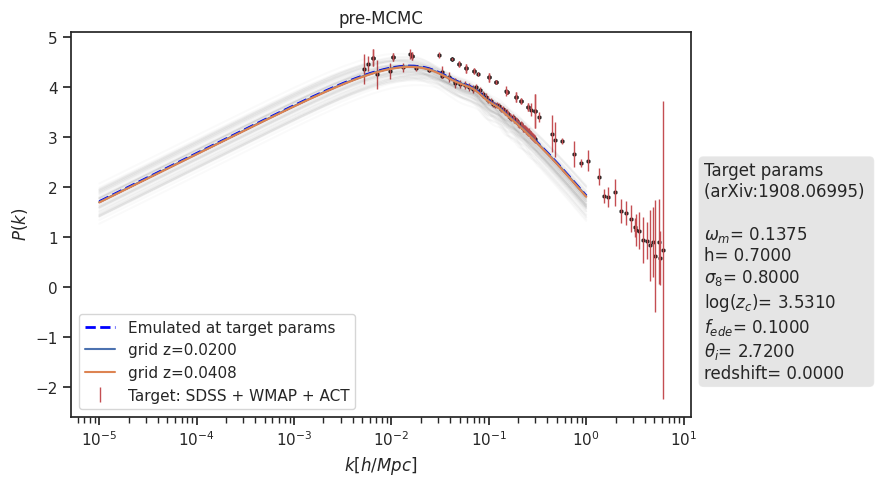

In [ ]:

f, a = plt.subplots(1,1, figsize = (8, 5)) 
input_params_and_redshift = np.append(params_calib, redshift)
bk_target, err_target = emu_redshift(input_params_and_redshift[np.newaxis, :], sepia_model_list, z_all)
a.plot(k_all, bk_target[:, 0], label='Emulated at target params', lw=2, ls='--', color='blue')

if create_mock_obs:
    data_label = 'Target mock observations'
else: 
    data_label = 'Target: SDSS + WMAP + ACT'

a.errorbar(x_target_mcmc, y_target_mcmc, yerr_target_mcmc, label=data_label, ls='none', lw=1, color = "r")
a.scatter(x_target_mcmc, y_target_mcmc, s = 5, marker = "h", color = "k")


a.plot(k_all, Pk_all[:, z_index, :].T, 'k', alpha=0.02)


plt.plot(k_all, emulate(sepia_model_list[z_index], input_params_and_redshift[:-1])[0], label='grid z=%.4f'%z_all[z_index])
plt.plot(k_all, emulate(sepia_model_list[z_index+1], input_params_and_redshift[:-1])[0], label='grid z=%.4f'%z_all[z_index + 1])



if create_mock_obs: string_print0 = 'Target Params \n (from sim) \n\n' 
if not create_mock_obs: string_print0 = 'Target params \n(arXiv:1908.06995) \n\n' 

string_print1 = PARAM_NAME[0] + '= %.4f'%input_params_and_redshift[0] + '\n'
string_print2 = PARAM_NAME[1] + '= %.4f'%input_params_and_redshift[1] + '\n'
string_print3 = PARAM_NAME[2] + '= %.4f'%input_params_and_redshift[2] + '\n'
string_print4 = PARAM_NAME[3] + '= %.4f'%input_params_and_redshift[3] + '\n'
string_print5 = PARAM_NAME[4] + '= %.4f'%input_params_and_redshift[4] + '\n'
string_print6 = PARAM_NAME[5] + '= %.4f'%input_params_and_redshift[5] + '\n'
string_print8 = 'redshift' + '= %.4f'%input_params_and_redshift[6] 


string_print = string_print0 + string_print1 + string_print2 + string_print3 + string_print4 + string_print5 + string_print6  + string_print8

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
plt.text(1.02, 0.1, string_print, transform=a.transAxes, fontsize=12, bbox=props)


a.set_xscale('log')
# a.set_yscale('log')
plt.title('pre-MCMC')
a.set_xlabel(r'$k [h/Mpc]$')
a.set_ylabel(r'$P(k)$')
plt.legend()

In [ ]:
#| hide 

allMax = np.max(p_all, axis = 0)
allMin = np.min(p_all, axis = 0)
allMean = np.mean(p_all, axis = 0)

param1 = [PARAM_NAME[0], params_calib[0][0], allMin[0], allMax[0]] 
param2 = [PARAM_NAME[1], params_calib[0][1], allMin[1], allMax[1]]
param3 = [PARAM_NAME[2], params_calib[0][2], allMin[2], allMax[2]]
param4 = [PARAM_NAME[3], params_calib[0][3], allMin[3], allMax[3]]
param5 = [PARAM_NAME[4], params_calib[0][4], allMin[4], allMax[4]]
param6 = [PARAM_NAME[5], params_calib[0][5], allMin[5], allMax[5]]


# param1 = [PARAM_NAME[0], allMean[0], allMin[0], allMax[0]] 
# param2 = [PARAM_NAME[1], allMean[1], allMin[1], allMax[1]]
# param3 = [PARAM_NAME[2], allMean[2], allMin[2], allMax[2]]
# param4 = [PARAM_NAME[3], allMean[3], allMin[3], allMax[3]]
# param5 = [PARAM_NAME[4], allMean[4], allMin[4], allMax[4]]
# param6 = [PARAM_NAME[5], allMean[5], allMin[5], allMax[5]]
# param7 = [PARAM_NAME[6], allMean[6], allMin[6], allMax[6]]

params_list = [param1, param2, param3, param4, param5, param6]

In [ ]:
pos0 = chain_init(params_list, ndim, nwalkers)

sampler = define_sampler(redshift, ndim, nwalkers, params_list, x_grid, sepia_model_list, z_all, x_target_mcmc, y_target_mcmc, yerr_target_mcmc)

##### MCMC run - first burn, then full. 


Burn-in phase
time (minutes): 0.6017665227254232


100%|███████████████████████████████████████████| 50/50 [00:32<00:00,  1.54it/s]


mcmc results: 0.14637000024895402 0.7051308553607339 0.811299909354517 3.530070978224219 0.0943624409669398 2.720905473749736


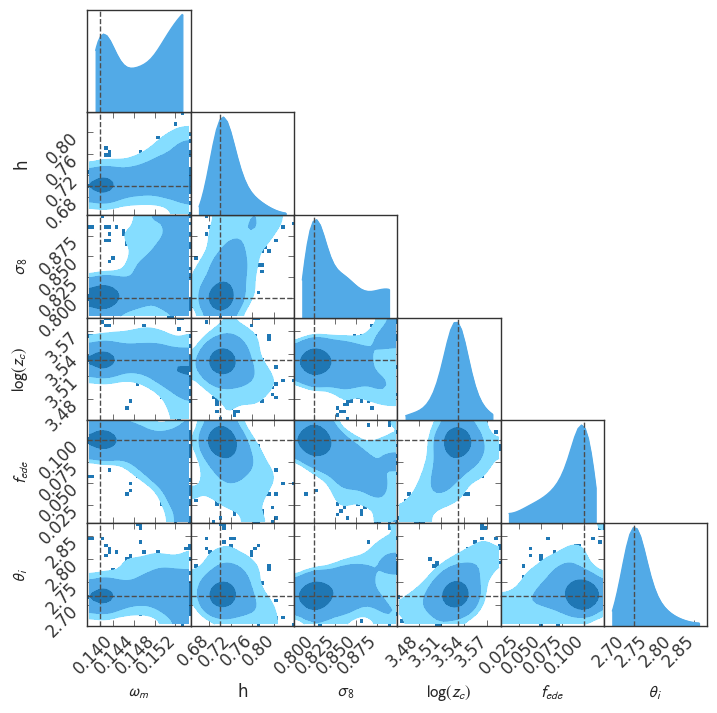

In [ ]:

pos, prob, state, samples, sampler, autocorr, index = do_mcmc(sampler, pos0, nrun_burn, ndim, if_burn=True)

if if_mcmc_all: # Full MCMC-run, will be slow
    pos, prob, state, samples, sampler, autocorr, index = do_mcmc(sampler, pos, nrun, ndim, if_burn=False)

p_mcmc = mcmc_results(samples)

fig = plot_mcmc(samples, params_list, if_truth_know=True)
# if if_savefig: 
#     plt.savefig('../../../Plots/mcmc_plot.png', bbox_inches='tight')

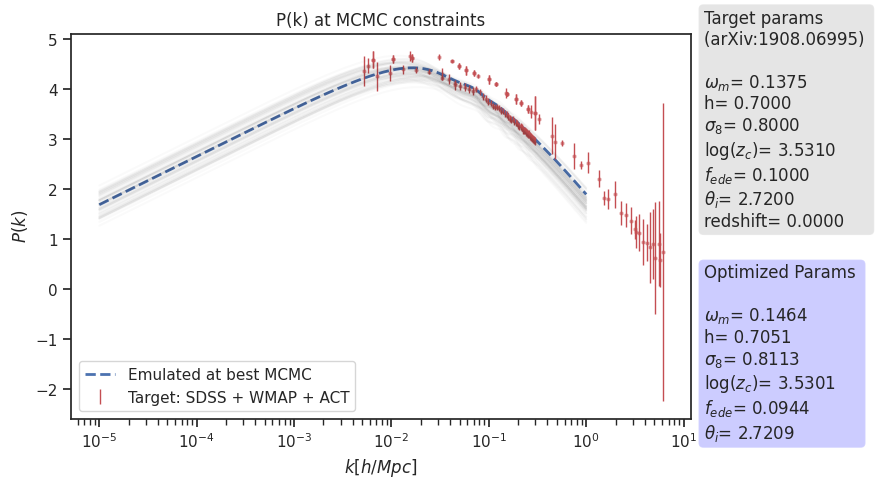

In [ ]:

f, a = plt.subplots(1,1, figsize = (8, 5)) 
input_params_and_redshift = np.append(p_mcmc, redshift)
bk_mcmc, err_mcmc = emu_redshift(input_params_and_redshift[np.newaxis, :], sepia_model_list, z_all)
a.plot(k_all, bk_mcmc[:, 0], label='Emulated at best MCMC', lw=2, ls='--')
a.errorbar(x_target_mcmc, y_target_mcmc, yerr_target_mcmc, label=data_label, ls='none', lw=1, color = "r")
a.scatter(x_target_mcmc, y_target_mcmc, s = 5, marker = "h", color = "r", alpha=0.5)

a.plot(k_all, Pk_all[:, z_index, :].T, 'k', alpha=0.02)


# plt.plot(k_all, emulate(sepia_model_list[z_index], input_params_and_redshift[:-1])[0], label='Z1')
# plt.plot(k_all, emulate(sepia_model_list[z_index+1], input_params_and_redshift[:-1])[0], label='Z2')


string_print1 = PARAM_NAME[0] + '= %.4f'%params_calib[0][0] + '\n'
string_print2 = PARAM_NAME[1] + '= %.4f'%params_calib[0][1] + '\n'
string_print3 = PARAM_NAME[2] + '= %.4f'%params_calib[0][2] + '\n'
string_print4 = PARAM_NAME[3] + '= %.4f'%params_calib[0][3] + '\n'
string_print5 = PARAM_NAME[4] + '= %.4f'%params_calib[0][4] + '\n'
string_print6 = PARAM_NAME[5] + '= %.4f'%params_calib[0][5] + '\n'
string_print8 = 'redshift' + '= %.4f'%redshift


string_print = string_print0 + string_print1 + string_print2 + string_print3 + string_print4 + string_print5 + string_print6  + string_print8

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
plt.text(1.02, 0.5, string_print, transform=a.transAxes, fontsize=12, bbox=props)

string_print0_mcmc = 'Optimized Params \n\n' 
string_print1_mcmc = PARAM_NAME[0] + '= %.4f'%p_mcmc[0] + '\n'
string_print2_mcmc = PARAM_NAME[1] + '= %.4f'%p_mcmc[1] + '\n'
string_print3_mcmc = PARAM_NAME[2] + '= %.4f'%p_mcmc[2] + '\n'
string_print4_mcmc = PARAM_NAME[3] + '= %.4f'%p_mcmc[3] + '\n'
string_print5_mcmc = PARAM_NAME[4] + '= %.4f'%p_mcmc[4] + '\n'
string_print6_mcmc = PARAM_NAME[5] + '= %.4f'%p_mcmc[5]

string_print_mcmc = string_print0_mcmc + string_print1_mcmc + string_print2_mcmc + string_print3_mcmc + string_print4_mcmc + string_print5_mcmc + string_print6_mcmc 

props = dict(boxstyle='round', facecolor='blue', alpha=0.2)
plt.text(1.02, -0.05, string_print_mcmc, transform=a.transAxes, fontsize=12, bbox=props)



a.set_xscale('log')
# a.set_yscale('log')
plt.title('P(k) at MCMC constraints')
a.set_xlabel(r'$k [h/Mpc]$')
a.set_ylabel(r'$P(k)$')
plt.legend()

if if_savefig: 
    plt.savefig('../../../Plots/mcmc_results_Bk.png', bbox_inches='tight')


In [ ]:
#| hide


if if_mcmc_all:
    tau = sampler.get_autocorr_time(tol=0)
    print(tau)

    plt.figure(43)
    plt.plot(prob)
    plt.show()
    if if_savefig: 
        plt.savefig('../../../Plots/prob_plot.png', bbox_inches='tight')

    # selected_indices_for_plot = [0, 2, 4]
    # fig = plot_mcmc(samples[:, selected_indices_for_plot], [params_list[i] for i in selected_indices_for_plot], if_truth_know=True)

    # if if_savefig: 
    #     plt.savefig('../../../Plots/mcmc_plot_reduced_params.png', bbox_inches='tight')

In [ ]:
#| hide


def plot_convergence(sampler, params_list, nrun, ndim, nwalkers):
    n_params = len(params_list)  # Number of parameters
    fig, ax = plt.subplots(n_params, 1, figsize=(20, 2 * n_params), sharex=True)
    ax[-1].set_xlabel('steps')

    for i, param in enumerate(params_list):
        ax[i].plot(np.arange(nrun), sampler.chain[:, :, i].T, lw=0.2, alpha=0.9)
        ax[i].text(0.9, 0.9, param[0], horizontalalignment='center', verticalalignment='center', transform=ax[i].transAxes, fontsize=12)

    # fig.savefig('plots/convergence_mcmc_ndim{}_nwalk{}_run{}_{}-{}.png'.format(ndim, nwalkers, nrun, summary_stat, design), dpi=100)

    return fig

if False:
    # Example usage
    plot_convergence(sampler, params_list, nrun, ndim, nwalkers)

In [ ]:
#| hide

if False:

    n = 100 * np.arange(1, index + 1)
    y_autocarr = autocorr[:index]
    plt.plot(n, n / 100.0, "--k")
    plt.plot(n, y_target_mcmc)
    plt.xlim(0, n.max())
    plt.ylim(0, y_autocarr.max() + 0.1 * (y_autocarr.max() - y_autocarr.min()))
    plt.xlabel("number of steps")
    plt.ylabel(r"mean $\hat{\tau}$");
    plt.show()

In [ ]:
#| hide

if False:
    plt.plot(autocorr)
    plt.xscale('log')
    # plt.yscale('log')

## Fisher matrix analysis

In [ ]:
#Fisher Class
import numpy as np
from scipy.integrate import simps

In [ ]:
#Defining the derivative and p(k) function
def power_spectra(params, redshift):
    params_and_redshift = np.append(params, redshift)
    # pred_mean, pred_err = emulate(sepia_model, params) ## -- use this emu_redshift -- change pred_error
    pred_mean, pred_err = emu_redshift(params_and_redshift[np.newaxis, :], sepia_model_list, z_all)
    return pred_mean[:, 0], pred_err[:, 0] ## Check how to scale P(k) and Pk_errors properly

In [ ]:
class FisherMatrix:
    def __init__(self, k_values, pk, pk_errors, params):
        self.k_values = np.array(k_values)
        self.pk = np.array(pk)
        self.pk_errors = np.array(pk_errors)
        self.params = np.array(params)
        # self.redshift = self.redshift
        self.n_params = len(params)
        self.fmat = np.zeros((self.n_params, self.n_params))

    def compute_fmat(self, derivatives):
        for i in range(self.n_params):
            for j in range(self.n_params):
                integrand = derivatives[i] * derivatives[j] / self.pk_errors**2
                # self.fmat[i, j] = np.sum(integrand)
                self.fmat[i, j] = simps(integrand, self.k_values)
        return self.fmat

    def uncertainty(self):
        if np.linalg.det(self.fmat) == 0:
            raise ValueError("Fisher is singular.")
        inv_fisher = np.linalg.inv(self.fmat)
        return np.sqrt(np.diagonal(inv_fisher))
    

def deriv(params, redshift, perturb = 1e-5):
    n_par = len(params)
    pk, _ = power_spectra(params, redshift)

    derivative = np.zeros((len(pk), len(pk)))

    for i in range(n_par):
        params_up  = params.copy()
        params_down  = params.copy()

        params_up[i] += perturb
        params_down[i] -= perturb

        # pk_up = power_spectra(kvals, params_up)
        # pk_down = power_spectra(kvals, params_down)
        pk_up, _ = power_spectra(params_up, redshift)
        pk_down, _ = power_spectra(params_down, redshift)

        derivative[i] = (pk_up - pk_down)/(2*perturb)
        
    return derivative, pk_up, pk_down


#Using the fmat above we want to calculate hessian ellipses --  need 2x2 matrices
def _2x2_matrices(matrix):
    n = matrix.shape[0]
    pairwise_matrices = []
    
    # Loop over all pairs (i, j) with i < j
    for i in range(n):
        for j in range(i + 1, n):
            # Create a 2x2 matrix from the pair
            pairwise_matrix = np.array([[matrix[i, i], matrix[i, j]],
                                         [matrix[j, i], matrix[j, j]]])
            pairwise_matrices.append(pairwise_matrix)
    
    return pairwise_matrices

#Regularizing the matrix before plotting - so it doesn't raise the "hessian is not neg def" error
def regularize_hessian(H, lambda_reg=1e-5):

    H = np.array(H)
    
    identity_matrix = np.eye(H.shape[0])
    H_regularized = H + lambda_reg * identity_matrix
    
    return H_regularized

In [ ]:
redshift_fid = 0.9
param_fid = np.array([0.13844, 0.6991, 0.7997, 3.530, 0.0993, 2.72])


pk_fid, pk_error_fid = power_spectra(param_fid, redshift_fid)
derivs, pk_up, pk_down = deriv(param_fid, redshift_fid)
k_values = np.log10(k_all)
fisher = FisherMatrix(k_values, pk_fid, pk_error_fid, param_fid)
fmat_fid = fisher.compute_fmat(derivs)
fish_all = np.array(_2x2_matrices(-fmat_fid))


In [ ]:
## Standalone test

In [ ]:
#We need to plot the 2x2 hessian ellipses - Function from Nesar
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np

In [ ]:
standalone_fisher_test = False

if standalone_fisher_test: 
        param_fiducial = np.array([0.13844, 0.6991, 0.7997, 3.530, 0.0993, 2.72])
        p_names = ['$\\omega_m$', 'h', '$\\sigma_8$', '$\\log(z_c)$', '$f_{ede}$', '$\\theta_i$']
        p_min = np.array([0.12, 0.55, 0.7 , 3.  , 0.  , 0.  ])
        p_max = np.array([0.155, 0.85 , 0.9  , 4.   , 0.5  , 3.14 ])

        fmat_fid = np.array([[  33602.33436514,  -16812.85135088,  -33306.49447045,
         -28651.99102799,    7955.28501939,  -19192.39592227],
       [ -16812.85135088,    8471.49395214,   12617.76405109,
          12309.1688204 ,    -599.4785199 ,    9966.86094666],
       [ -33306.49447045,   12617.76405109,  309579.52928037,
         166905.49266398, -238929.54284678,   -5850.67462856],
       [ -28651.99102799,   12309.1688204 ,  166905.49266398,
          93795.30933078, -122491.4294374 ,    3907.87406654],
       [   7955.28501939,    -599.4785199 , -238929.54284678,
        -122491.4294374 ,  194898.50173265,   16236.1357093 ],
       [ -19192.39592227,    9966.86094666,   -5850.67462856,
           3907.87406654,   16236.1357093 ,   13199.13065175]])

else: 
        param_fiducial = p_mcmc
        p_names = PARAM_NAME
        p_min = allMin
        p_max = allMax

In [ ]:

def plot_contours(hessian, pos, nstd=1., ax=None, **kwargs):
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:, order]

    # Ensure Hessian is negative definite for covariance inversion
    if np.all(np.linalg.eigvals(-hessian) > 0):
        mat = -hessian
    else:
        raise ValueError("The Hessian is not negative definite.")
    cov = np.linalg.pinv(mat)
    
    # Check for valid covariance values
    if not np.all(np.isfinite(cov)):
        raise ValueError("Covariance matrix contains NaN or Inf.")

    sigma_marg = lambda i: np.sqrt(cov[i, i])

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    if np.any(vals < 0):
        raise ValueError("Negative eigenvalues found in covariance matrix.")

    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(np.abs(vals))
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

    ax.add_artist(ellip)
    sz = max(width, height)
    s1 = 1.5 * nstd * sigma_marg(0)
    s2 = 1.5 * nstd * sigma_marg(1)

    ax.axhline(pos[1], color='blue')
    ax.axvline(pos[0], color='blue')

    ax.set_xlim(pos[0] - s1, pos[0] + s1)
    ax.set_ylim(pos[1] - s2, pos[1] + s2)
    plt.draw()
    return ellip

###################################################################

def plot_fisher_grid_aligned(param_names, param_fiducial, fisher_matrix_6x6):
    n_params = len(param_names)
    fig, axes = plt.subplots(nrows=n_params, ncols=n_params, figsize=(16, 14), sharex='col', sharey='row')
    fig.subplots_adjust(top=0.9, right=0.9, left=0.0, bottom=0.0, hspace=0.01, wspace=0.01)

    neg_fmat = -fisher_matrix_6x6

    for i in range(n_params):
        for j in range(n_params):
            if i > j:
                ax = axes[i, j]
                param_duo = np.array([param_fiducial[j], param_fiducial[i]])
                fish2x2 = np.array([[neg_fmat[j, j], neg_fmat[j, i]], [neg_fmat[i, j], neg_fmat[i, i]]])
                
                plot_contours(fish2x2, param_duo, nstd=1., ax=ax, alpha=0.4, fill=True, edgecolor='red', linewidth=2)

                if j == 0:
                    ax.set_ylabel(param_names[i], fontsize=12)
                if i == n_params - 1:
                    ax.set_xlabel(param_names[j], fontsize=12)
            else:
                axes[i, j].axis('off')

    fig.tight_layout()
    fig.show()


def plot_fisher_grid_multiple(param_names, param_fiducial, fisher_matrices, matrix_labels):
    n_params = len(param_names)
    n_matrices = len(fisher_matrices)

    fig, axes = plt.subplots(nrows=n_params, ncols=n_params, figsize=(16, 14), sharex='col', sharey='row')
    plt.subplots_adjust(top=0.90, right=0.85, left=0.08, bottom=0.08, hspace=0.4, wspace=0.4)

    colors = ['red', 'blue', 'green', 'purple']  # Adjust as needed
    legend_handles = []

    for i in range(n_params):
        for j in range(n_params):
            if i > j:
                ax = axes[i, j]
                param_duo = np.array([param_fiducial[j], param_fiducial[i]])

                # Plot ellipses for each Fisher matrix
                for k, (fisher_matrix, label) in enumerate(zip(fisher_matrices, matrix_labels)):
                    neg_fmat = -fisher_matrix
                    fish2x2 = np.array([[neg_fmat[j, j], neg_fmat[j, i]], 
                                        [neg_fmat[i, j], neg_fmat[i, i]]])

                    ellip = plot_contours(fish2x2, param_duo, nstd=1., ax=ax, 
                                          alpha=0.3, fill=True, edgecolor=colors[k], 
                                          linewidth=2)

                    if i == n_params - 1 and j == 0:
                        legend_handles.append((ellip, label))  # Collect handles and labels

                if j == 0:
                    ax.set_ylabel(param_names[i], fontsize=12)
                if i == n_params - 1:
                    ax.set_xlabel(param_names[j], fontsize=12)

            else:
                axes[i, j].axis('off')

    # Create a single legend outside the plot
    # fig.legend(*zip(*legend_handles), loc='center right', fontsize=10)
    fig.legend(*zip(*legend_handles), loc='center', fontsize=14, 
               bbox_to_anchor=(0.5, 0.7), ncol=1, frameon=True)

    plt.tight_layout()
    plt.show()

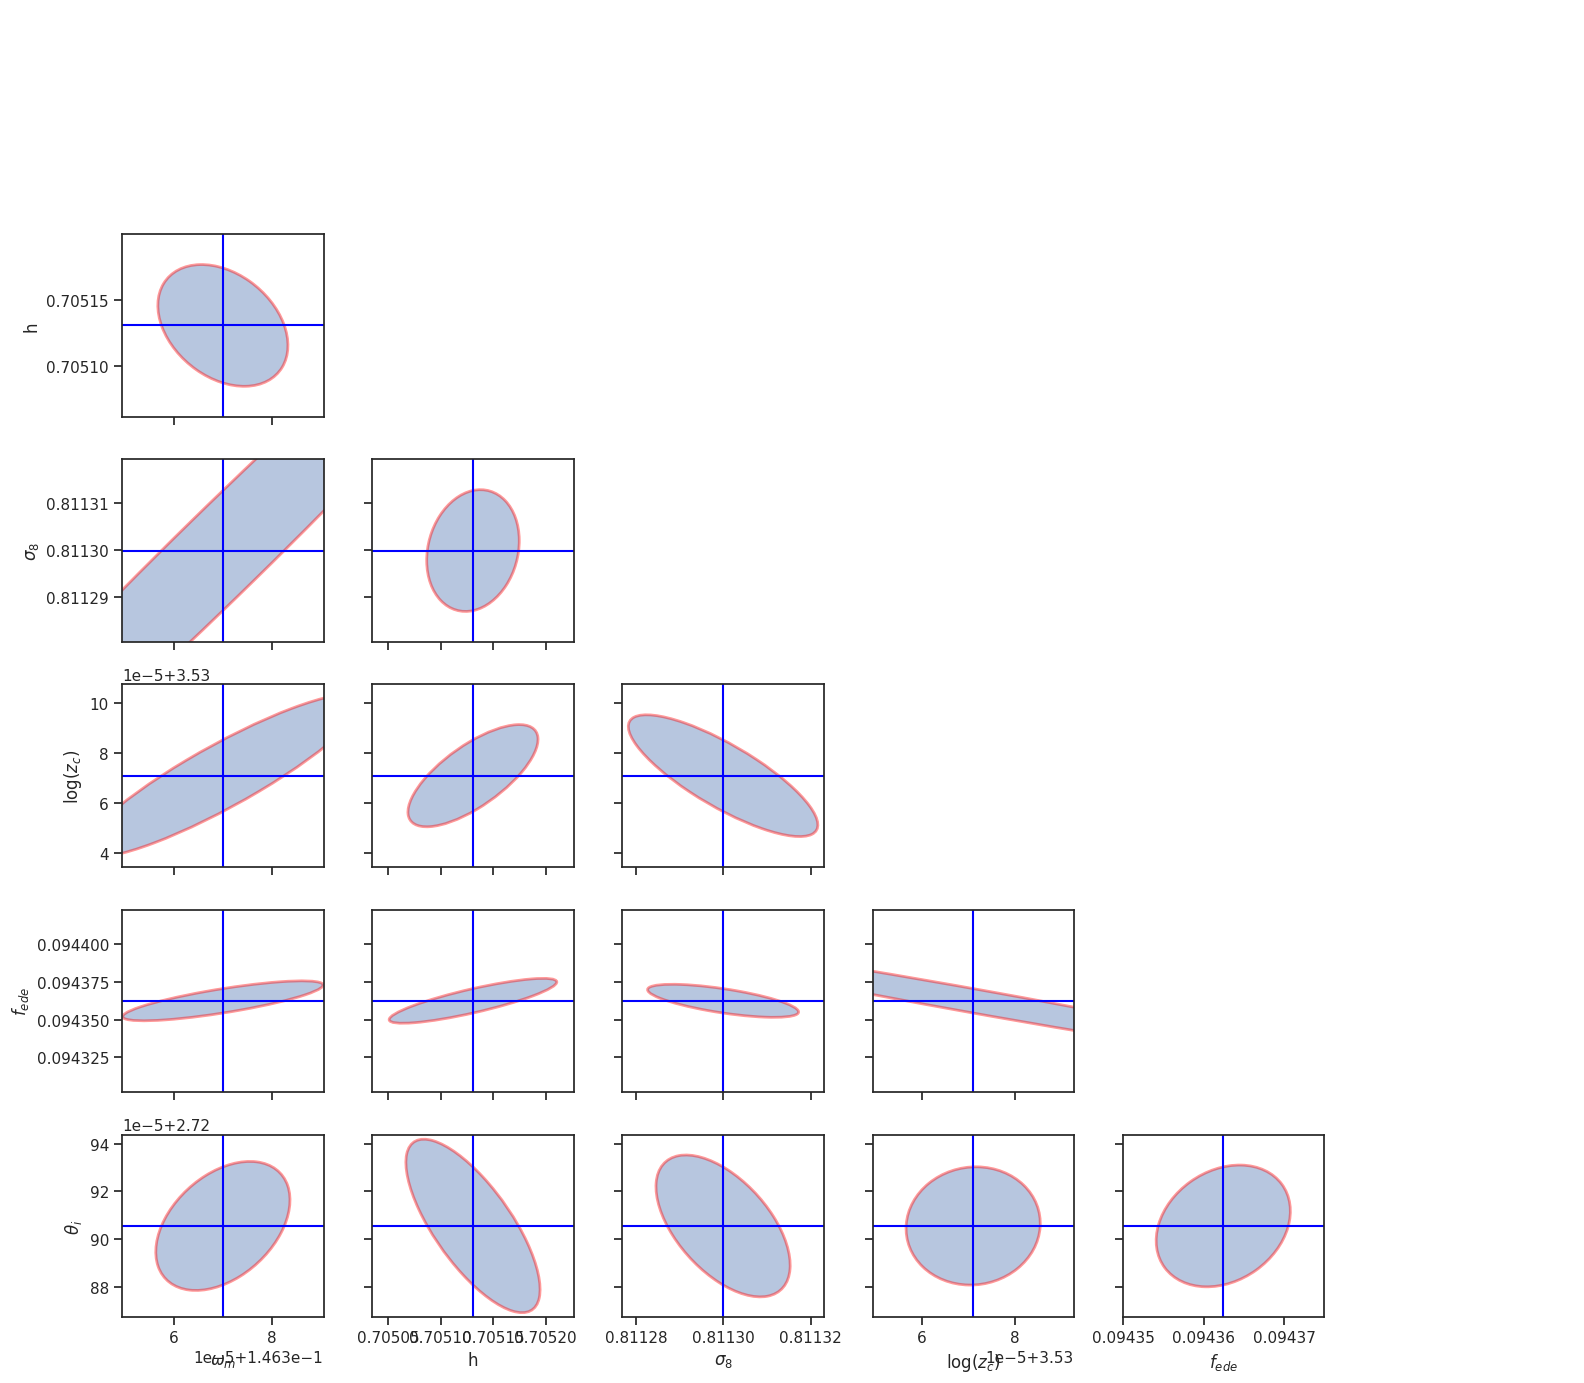

In [ ]:
plot_fisher_grid_aligned(p_names, param_fiducial, fmat_fid)

In [ ]:
## Different redshifts

In [ ]:
redshift_fid = 0.9
param_fid = np.array([0.13844, 0.6991, 0.7997, 3.530, 0.0993, 2.72])

def computs_fisher_mat(redshift_fid):

    pk_fid, pk_error_fid = power_spectra(param_fid, redshift_fid)
    derivs, pk_up, pk_down = deriv(param_fid, redshift_fid)
    k_values = np.log10(k_all)
    fisher = FisherMatrix(k_values, pk_fid, pk_error_fid, param_fid)
    fmat_fid = fisher.compute_fmat(derivs)
    fish_all = np.array(_2x2_matrices(-fmat_fid))

    return fmat_fid

param_fid = np.array([0.13844, 0.6991, 0.7997, 3.530, 0.0993, 2.72])

fmat_fid_z01 = computs_fisher_mat(redshift_fid = 0.01)
fmat_fid_z05 = computs_fisher_mat(redshift_fid = 0.25)
fmat_fid_z10 = computs_fisher_mat(redshift_fid = 0.5)


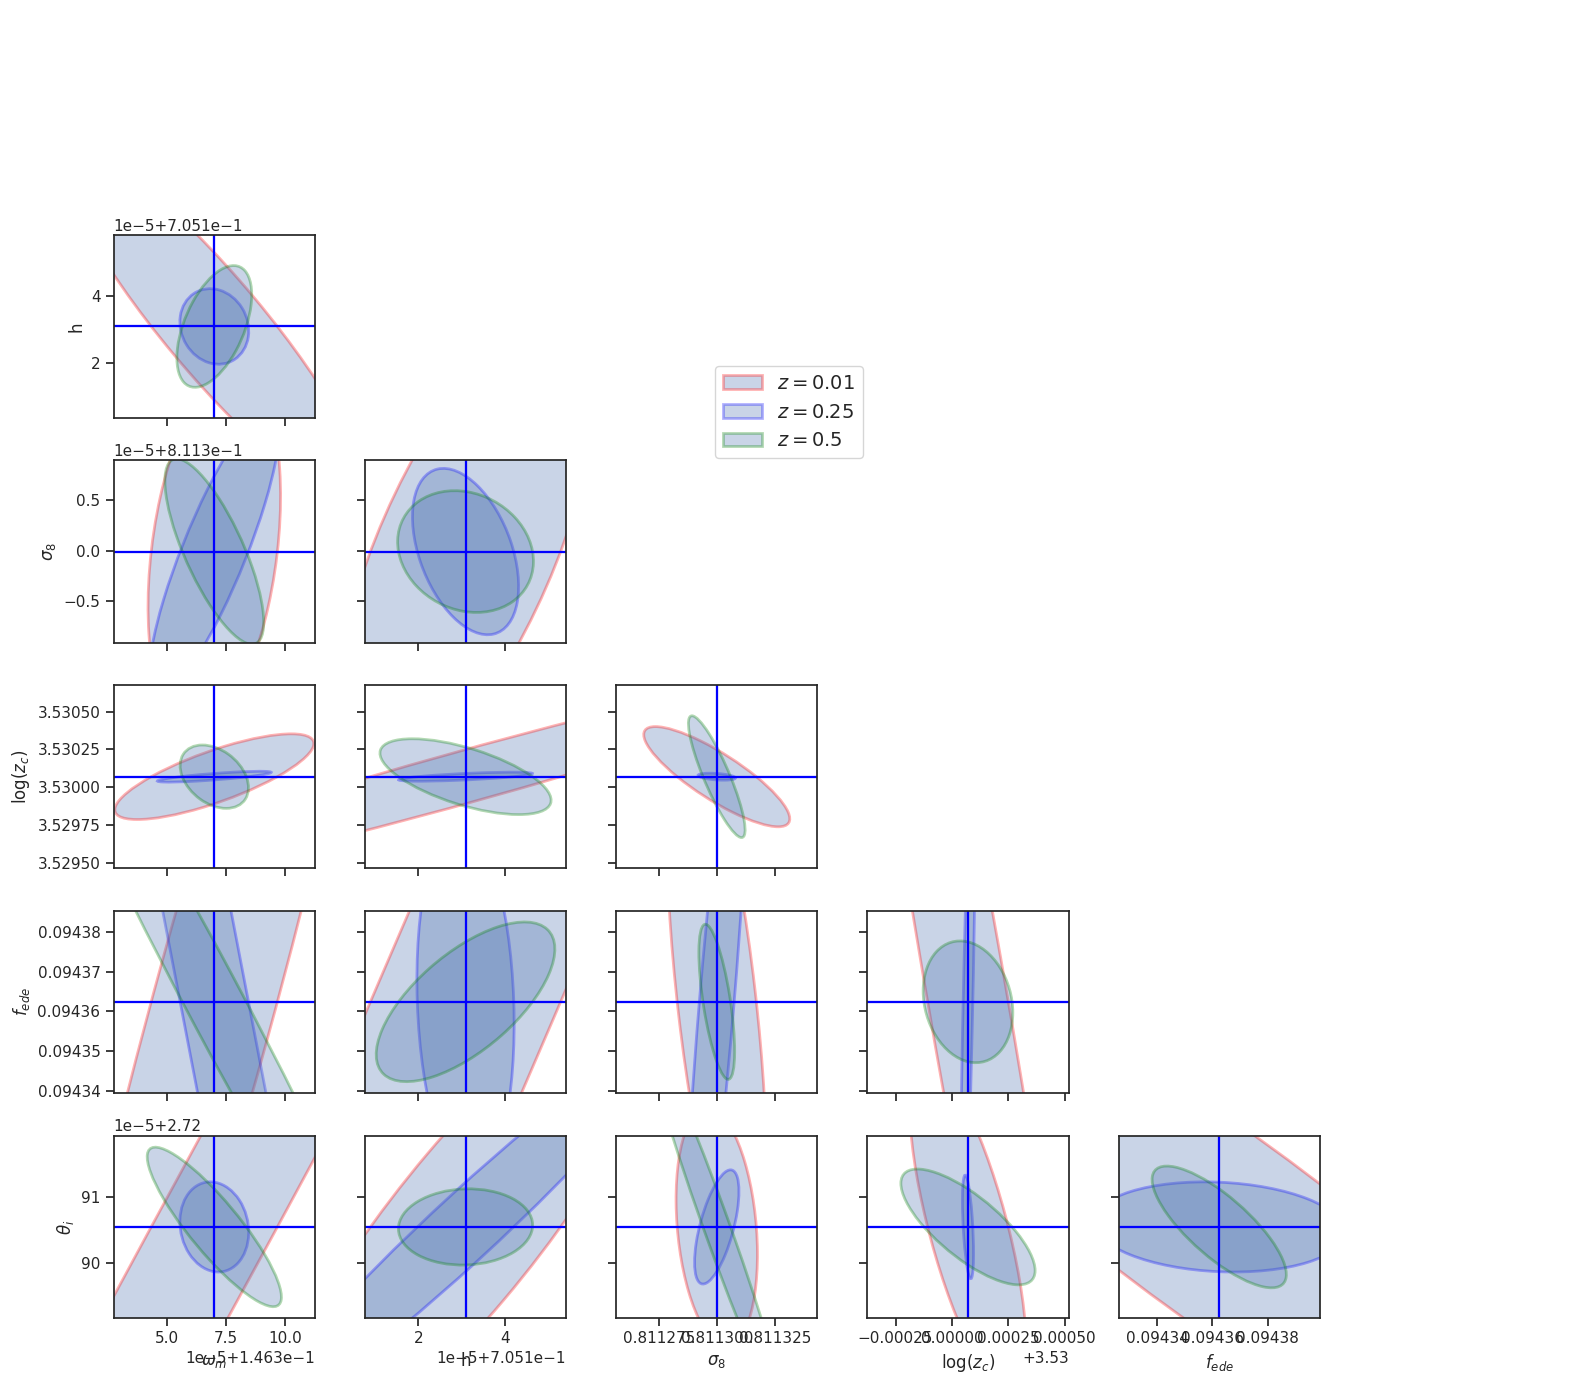

In [ ]:
# Example usage:
fisher_matrices = [fmat_fid_z01, fmat_fid_z05, fmat_fid_z10] 
matrix_labels = [r'$z=0.01$', r'$z=0.25$', r'$z=0.5$']
plot_fisher_grid_multiple(p_names, param_fiducial, fisher_matrices, matrix_labels)